# Import necessary libraries

In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from glob import glob
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from itertools import chain
import matplotlib.pyplot as plt

# Configuration parameters

In [2]:
BASE_DATA_PATH = '../data/NIH_Dataset'  # Update this path according to your directory structure
MODEL_SAVE_PATH = 'model_weights/best_model.pth'
GRAPHS_SAVE_PATH = 'performance_graphs/plot'
FINDING_LABELS_COLUMN = 'Finding Labels'
CSV_FILE = os.path.join(BASE_DATA_PATH, 'Data_Entry_2017.csv')
IMAGE_PATH_PATTERN = os.path.join(BASE_DATA_PATH, 'images_*', 'images', '*.png')
BATCH_SIZE = 32
VAL_BATCH_SIZE = 256
NUM_EPOCHS = 25

# Load image lists

In [3]:
def load_image_lists():
    with open(os.path.join(BASE_DATA_PATH, 'train_val_list.txt'), 'r') as file:
        train_val_images = file.read().splitlines()
    with open(os.path.join(BASE_DATA_PATH, 'test_list.txt'), 'r') as file:
        test_images = file.read().splitlines()
    return train_val_images, test_images

# Load data

In [4]:

def load_data():
    train_val_images, test_images = load_image_lists()
    
    data = pd.read_csv(CSV_FILE)
    data = data[data['Patient Age'] < 100]
    data['image_file'] = data['Image Index'].apply(lambda x: x.split('.')[0] + '.png')
    image_paths = glob(IMAGE_PATH_PATTERN)
    image_path_dict = {os.path.basename(path): path for path in image_paths}
    data['path'] = data['image_file'].map(image_path_dict.get)
    
    train_val_data = data[data['image_file'].isin(train_val_images)]
    test_data = data[data['image_file'].isin(test_images)]
    
    train_val_data[FINDING_LABELS_COLUMN] = train_val_data[FINDING_LABELS_COLUMN].apply(lambda x: x.replace('No Finding', ''))
    test_data[FINDING_LABELS_COLUMN] = test_data[FINDING_LABELS_COLUMN].apply(lambda x: x.replace('No Finding', ''))
    
    all_labels = sorted(np.unique(list(chain(*train_val_data[FINDING_LABELS_COLUMN].map(lambda x: x.split('|')).tolist()))))
    for label in all_labels:
        train_val_data[label] = train_val_data[FINDING_LABELS_COLUMN].apply(lambda x, lbl=label: 1.0 if lbl in x else 0)
        test_data[label] = test_data[FINDING_LABELS_COLUMN].apply(lambda x, lbl=label: 1.0 if lbl in x else 0)
    
    return train_val_data, test_data, all_labels

# Define the ChestXrayDataset

In [5]:
class ChestXrayDataset(Dataset):
    def __init__(self, dataframe, labels, transform=None):
        self.dataframe = dataframe
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['path']
        image = Image.open(img_path).convert('RGB')
        label = self.dataframe.iloc[idx][self.labels].values.astype(np.float32)
        if self.transform:
            image = self.transform(image)
        return image, label

# Prepare data loaders

In [6]:
def get_transforms():
    return transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Grayscale(),  # Converts images to grayscale
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485], std=[0.229])  # Adjusted for a single channel
    ])

In [7]:
def prepare_data_loaders(data, all_labels, batch_size=BATCH_SIZE, val_batch_size=VAL_BATCH_SIZE):
    dataset = ChestXrayDataset(data, all_labels, transform=get_transforms())
    train_size = int(0.75 * len(dataset))
    valid_size = len(dataset) - train_size
    train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=val_batch_size, shuffle=False)
    return train_loader, valid_loader

def prepare_test_loader(test_data, all_labels, batch_size=VAL_BATCH_SIZE):
    test_dataset = ChestXrayDataset(test_data, all_labels, transform=get_transforms())
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return test_loader

# Load data

In [8]:
train_val_data, test_data, all_labels = load_data()
train_loader, valid_loader = prepare_data_loaders(train_val_data, all_labels)
test_loader = prepare_test_loader(test_data, all_labels)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_20920\2853163746.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_val_data[FINDING_LABELS_COLUMN] = train_val_data[FINDING_LABELS_COLUMN].apply(lambda x: x.replace('No Finding', ''))
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_20920\2853163746.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[FINDING_LABELS_COLUMN] = test_data[FINDING_LABELS_COLUMN].apply(lambda x: x.replace('No Finding', ''))
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_2

# Visualize sample images from each loader

Training Samples:


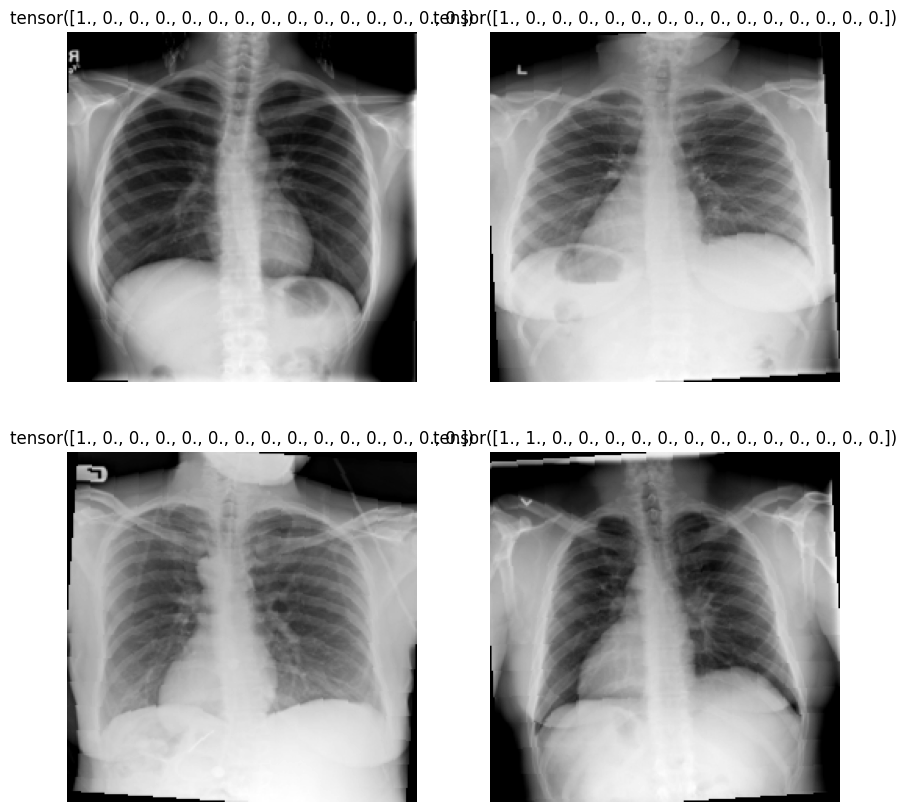

Validation Samples:


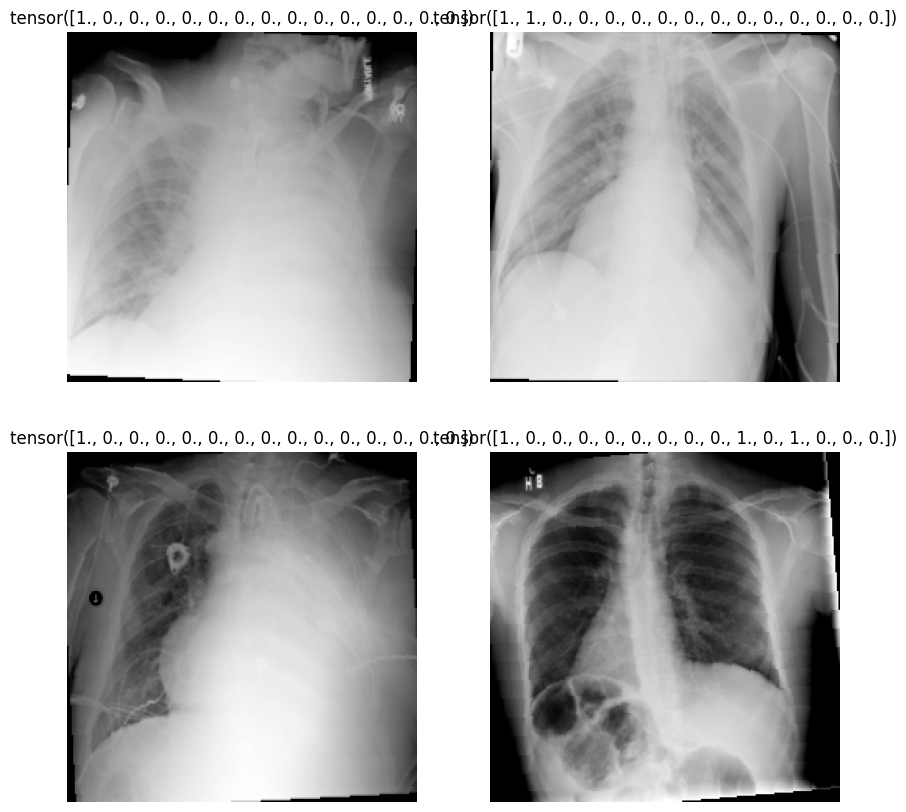

Test Samples:


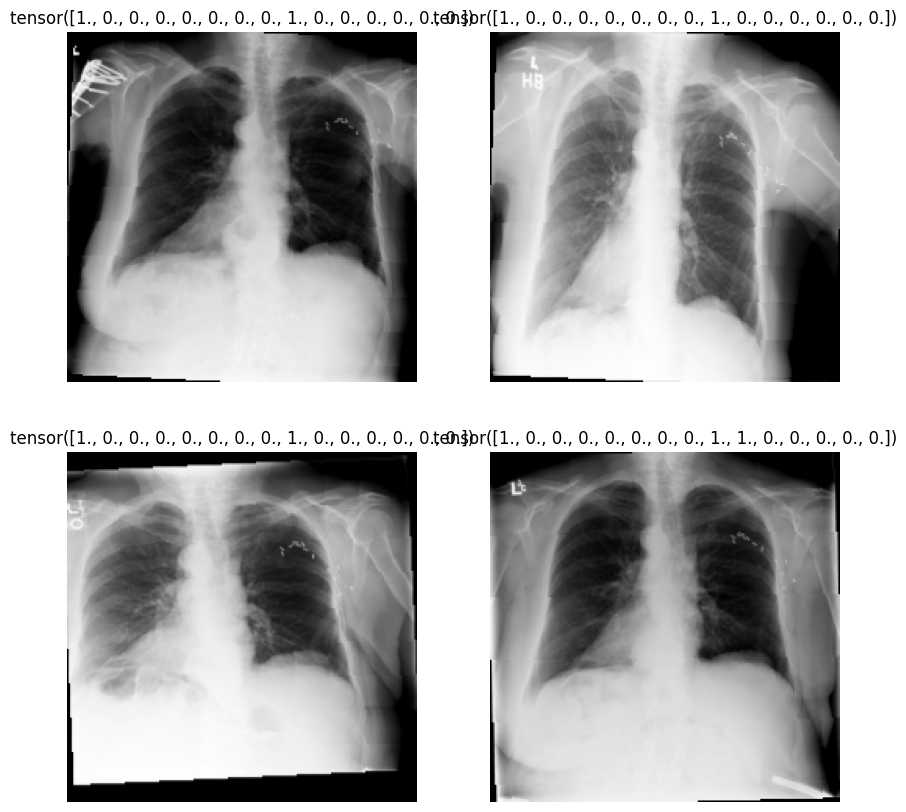

In [9]:
def show_images(loader):
    images, labels = next(iter(loader))
    plt.figure(figsize=(10, 10))
    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        img = images[i].numpy().transpose((1, 2, 0))
        if img.shape[2] == 1:  # Grayscale image
            img = img[:, :, 0]  # Remove the last dimension
            img = img * 0.225 + 0.406  # Adjust normalization for single channel
        else:  # RGB image
            img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        plt.imshow(img, cmap='gray' if img.ndim == 2 else None)
        plt.title(str(labels[i]))
        plt.axis("off")
    plt.show()

# Display images
print("Training Samples:")
show_images(train_loader)
print("Validation Samples:")
show_images(valid_loader)
print("Test Samples:")
show_images(test_loader)